In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import data
Import data from csv file.

In [34]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# import data from arff file
df_train = pd.read_csv('KDDTrain+.txt',delimiter=',', header=None)
df_test = pd.read_csv('KDDTest+.txt',delimiter=',', header=None)

df_train.columns = ['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'difficulty']

df_test.columns = df_train.columns
# convert class label
df_train.shape

(125973, 43)

Class label aggregation

In [35]:
class_DoS = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 
             'processtable', 'smurf', 'teardrop', 'udpstorm']
class_Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']

class_U2R = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'httptunnel', 'xterm']

class_R2L = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 
             'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 
             'warezmaster', 'xlock', 'xsnoop', 'worm']

df_train['class'] = df_train['attack']
df_train['class'].replace(class_DoS, value='DoS', inplace=True)
df_train['class'].replace(class_Probe, value='Probe',inplace=True)
df_train['class'].replace(class_U2R, value='U2R',inplace=True)
df_train['class'].replace(class_R2L, value='R2L', inplace=True)
print(df_train['class'].unique())

['normal' 'DoS' 'R2L' 'Probe' 'U2R']


In [36]:
print(df_train['class'].value_counts())

normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: class, dtype: int64


In [37]:
df_test['class'] = df_test['attack']
df_test['class'].replace(class_DoS, value='DoS', inplace=True)
df_test['class'].replace(class_Probe, value='Probe',inplace=True)
df_test['class'].replace(class_U2R, value='U2R',inplace=True)
df_test['class'].replace(class_R2L, value='R2L', inplace=True)
print(df_test['class'].unique())

['DoS' 'normal' 'Probe' 'R2L' 'U2R']


Convert nominal labels to numeric

In [38]:
labels={"normal": 0, "DoS": 1, "Probe": 2, "U2R": 3, "R2L":4}
df_train['class'] = df_train['class'].replace(labels)
df_test['class'] = df_test['class'].replace(labels)
print(df_train['class'].value_counts())

0    67343
1    45927
2    11656
4      995
3       52
Name: class, dtype: int64


Drop attack types and difficulty features

In [39]:
df_train = df_train.drop(['attack', 'difficulty'], axis=1)

In [40]:
print('Training set:')
for col_name in df_train.columns:
    if df_train[col_name].dtypes == 'object' :
        unique_cat = len(df_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories


split dataset into features and labels

In [41]:

x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, [-1]]
x_test = df_train.iloc[:, :-1]
y_test = df_train.iloc[:, [-1]]

one hot encoder

In [42]:

one_hot = pd.get_dummies(x_train['protocol_type'], prefix='protocol')
x_train = x_train.drop('protocol_type',axis = 1)
x_train = x_train.join(one_hot)

one_hot = pd.get_dummies(x_train['service'], prefix='service')
x_train = x_train.drop('service',axis = 1)
x_train = x_train.join(one_hot)

one_hot = pd.get_dummies(x_train['flag'], prefix='flag')
x_train = x_train.drop('flag',axis = 1)
x_train = x_train.join(one_hot)

one_hot = pd.get_dummies(x_test['protocol_type'], prefix='protocol')
x_test = x_test.drop('protocol_type',axis = 1)
x_test = x_test.join(one_hot)

one_hot = pd.get_dummies(x_test['service'], prefix='service')
x_test = x_test.drop('service',axis = 1)
x_test = x_test.join(one_hot)

one_hot = pd.get_dummies(x_test['flag'], prefix='flag')
x_test = x_test.drop('flag',axis = 1)
x_test = x_test.join(one_hot)

Use Isolation Forest to remove outliers

In [43]:
from sklearn.ensemble import IsolationForest
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(x_train.values)

# select all rows that are not outliers
mask = yhat != -1
x_train, y_train = x_train[mask], y_train[mask]

In [44]:
x_train.shape

(113376, 122)

Normalize numeric data by MinMaxScaler

In [45]:
x_train = pd.DataFrame(preprocessing.minmax_scale(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(preprocessing.minmax_scale(x_test), index=x_test.index, columns=x_test.columns)

# feature selection and resampling

Feature selection by Extra Trees classifier

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
model = SelectFromModel(clf, prefit=True)
clf.fit(x_train,np.ravel(y_train))
x_train = x_train[x_train.columns[model.get_support(indices=True)]]
x_train.shape

(113376, 29)

In [47]:
x_test = x_test[x_test.columns.intersection(x_train.columns)]

SMOTE oversampling

In [48]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, np.ravel(y_train))
x_smote = pd.DataFrame(x_smote, columns=x_train.columns)
print("The number of oversampled data:", len(y_smote))
print("The number of each class in oversampled data:", len(y_smote == 0))

The number of oversampled data: 319390
The number of each class in oversampled data: 319390


SMOTE+Gaussian(reproduce)

In [49]:
from collections import Counter
a = 25195
from imblearn.over_sampling import SMOTE
smo = SMOTE(sampling_strategy={2:a,3:a,4:a},random_state=42)
X_smo, y_smo = smo.fit_resample(x_train, np.ravel(y_train))   
print(sorted(Counter(y_smo).items()))

##
list0 = []  
list1 = []  
list2 = []
listy = [] 
X_smo=np.array(X_smo)
for i in range(X_smo.shape[0]):
  if y_smo[i]==0:
    list0.append(X_smo[i])
  elif y_smo[i]==1:
    list1.append(X_smo[i])
  else:
    list2.append(X_smo[i])
    listy.append(y_smo[i])
    
data0 = np.array(list0)  
data1 = np.array(list1)
data2 = np.array(list2)
label = np.array(listy)
label11 = label.reshape(label.shape[0],) 

#Gaussian
from sklearn.mixture import BayesianGaussianMixture
estimator0 = BayesianGaussianMixture(n_components=5)
estimator0.fit(data0) 
estimator1 = BayesianGaussianMixture(n_components=5)
estimator1.fit(data1) 

label_pred0 = estimator0.predict(data0) 
label_pred1 = estimator1.predict(data1) 


[(0, 63878), (1, 43638), (2, 25195), (3, 25195), (4, 25195)]


In [50]:
sorted(Counter(label_pred0).items())

[(0, 8889), (1, 31723), (2, 10775), (3, 10149), (4, 2342)]

In [51]:
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
s0=s1=s2=s3=s4=0

for i in range(data0.shape[0]):
    if label_pred0[i] == 0:
        c0.append(data0[i])
        s0=s0+1
    elif label_pred0[i] == 1:
        c1.append(data0[i])
        s1=s1+1
    elif label_pred0[i] == 2:
        c2.append(data0[i])
        s2=s2+1
    elif label_pred0[i] == 3:
        c3.append(data0[i])
        s3=s3+1
    elif label_pred0[i] == 4:
        c4.append(data0[i])
        s4=s4+1

a=5039
del c0[a:len(c0)]
del c3[a:len(c3)]
del c4[a:len(c4)]
del c1[a:len(c1)]
del c2[a:len(c2)]
q = np.concatenate((np.array(c0),np.array(c1),np.array(c2),np.array(c3),np.array(c4)),axis=0)
label_zc = np.zeros((q.shape[0],), dtype=int)

data_end = np.concatenate((q,data2),axis=0)
label_end = np.concatenate((label_zc,label11),axis=0)

In [52]:
sorted(Counter(label_pred1).items())

[(0, 21540), (1, 6135), (2, 2318), (3, 12750), (4, 895)]

In [53]:
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
s0=s1=s2=s3=s4=0

for i in range(data1.shape[0]):
    if label_pred1[i] == 0:
        c0.append(data1[i])
        s0=s0+1
    elif label_pred1[i] == 1:
        c1.append(data1[i])
        s1=s1+1
    elif label_pred1[i] == 2:
        c2.append(data1[i])
        s2=s2+1
    elif label_pred1[i] == 3:
        c3.append(data1[i])
        s3=s3+1
    elif label_pred1[i] == 4:
        c4.append(data1[i])
        s4=s4+1

a=7731
del c0[a:len(c0)]
del c3[a:len(c3)]
del c4[a:len(c4)]
del c1[a:len(c1)]
del c2[a:len(c2)]
q1 = np.concatenate((np.array(c0),np.array(c1),np.array(c2),np.array(c3),np.array(c4)),axis=0)
label_zc = np.ones((q1.shape[0],), dtype=int)

data_end = np.concatenate((q1,data_end),axis=0)
label_end = np.concatenate((label_zc,label_end),axis=0)
sorted(Counter(label_end).items())

[(0, 22498), (1, 24810), (2, 25195), (3, 25195), (4, 25195)]

# results

Extra Trees

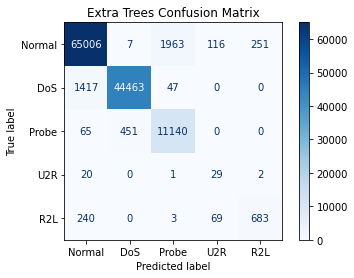

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
clf_et = ExtraTreesClassifier()
clf_et.fit(x_smote, np.ravel(y_smote))
ConfusionMatrixDisplay.from_estimator(clf_et, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("Extra Trees Confusion Matrix")
plt.show() 
print()

In [67]:
y_pred = clf_et.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.9630714518190406
Precision: 0.7351623431868386
Recall: 0.8266551619944849
F1: 0.7543799469435677


KNN

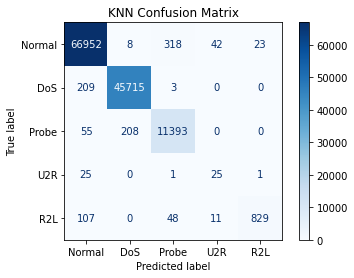

In [56]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(x_smote, np.ravel(y_smote))
ConfusionMatrixDisplay.from_estimator(clf_knn, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("KNN Confusion Matrix")
plt.show() 
print()

In [57]:
y_pred = clf_knn.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.9915934366888143
Precision: 0.8500679310799949
Recall: 0.8561898910154457
F1: 0.848853965497633


Random Forest

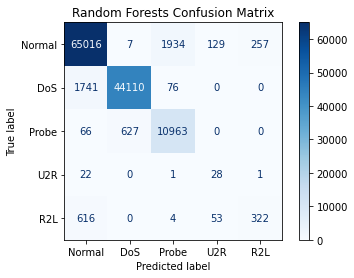

In [58]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=35)
clf_rf.fit(x_smote, np.ravel(y_smote))
ConfusionMatrixDisplay.from_estimator(clf_rf, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("Random Forest Confusion Matrix")
plt.show() 
print()

In [59]:
y_pred = clf_rf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.9560699514975431
Precision: 0.6965660668947603
Recall: 0.7457016082141432
F1: 0.6900537283344843


SVM

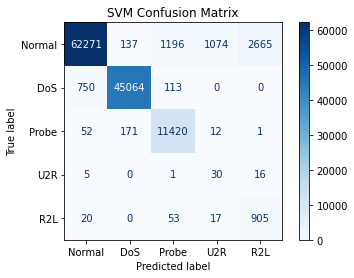

In [72]:
from sklearn.svm import SVC
clf_svm=SVC()
clf_svm.fit(x_smote, np.ravel(y_smote))
ConfusionMatrixDisplay.from_estimator(clf_svm, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("SVM Confusion Matrix")
plt.show() 
print()

In [73]:
y_pred = clf_svm.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.9501242329705571
Precision: 0.6304514873566208
Recall: 0.8744234246009839
F1: 0.6644358418043337


## reproduce result

Extra Trees

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


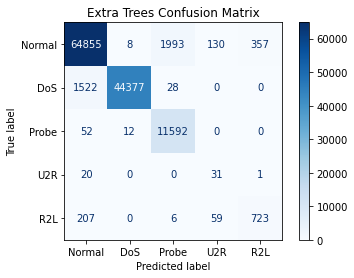

In [68]:

from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
clf_et.fit(data_end, label_end)
ConfusionMatrixDisplay.from_estimator(clf_et, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("Extra Trees Confusion Matrix")
plt.show() 
print()

In [69]:
y_pred = clf_et.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.965111571527232
Precision: 0.726685652814857
Recall: 0.8493203751712789
F1: 0.7584706853576412


KNN

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


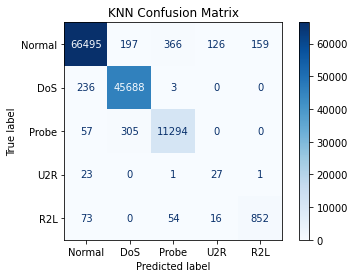

In [62]:
clf_knn.fit(data_end, np.ravel(label_end))
ConfusionMatrixDisplay.from_estimator(clf_knn, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("KNN Confusion Matrix")
plt.show() 
print()

In [63]:
y_pred = clf_knn.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.9871639160772546
Precision: 0.7897585409467399
Recall: 0.8653318095471093
F1: 0.8084970671185367


Random Forest

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


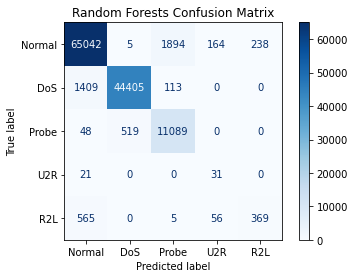

In [64]:
clf_rf.fit(data_end, label_end)
ConfusionMatrixDisplay.from_estimator(clf_rf, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("Random Forest Confusion Matrix")
plt.show() 
print()

In [65]:
y_pred = clf_rf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.960015241361244
Precision: 0.7071441817216364
Recall: 0.7702111466102859
F1: 0.7012576429131453


SVM

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


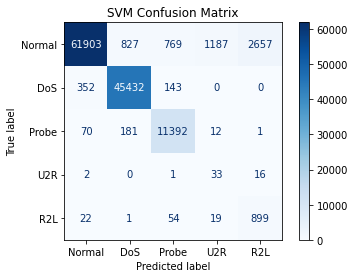

In [74]:
clf_svm.fit(data_end, label_end)
ConfusionMatrixDisplay.from_estimator(clf_svm, x_test, y_test, values_format='g', cmap=plt.cm.Blues, display_labels=['Normal','DoS','Probe','U2R','R2L'])
plt.title("SVM Confusion Matrix")
plt.show() 
print()

In [75]:
y_pred = clf_svm.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))

/Users/tiffcheng/opt/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy: 0.9498781484921373
Precision: 0.634173167705223
Recall: 0.8847850474926051
F1: 0.6662666545033488
